### load

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import time
import pandas as pd
from IPython.display import display
from utils import nba_inference_utils as niu
import matplotlib.pyplot as plt
import joblib 
import pprint as pp
from datetime import datetime
# create pretty printer
pp = pp.PrettyPrinter(indent=4)
import warnings
warnings.simplefilter(action='ignore')

train_cols = ['Opp_Elo', 'Opp_Momentum', 'SPREAD_LINE_MOVEMENT_1', 
              'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3', 
                'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2',
                'TOTAL_LINE_MOVEMENT_3', 'CREW', 'Opp_Avg_3_game_DEFF',
                'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF',
                'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF',
                'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE',
                'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE',
                'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS',
                'Opp_Season_Avg_POSS', 'Avg_3_game_DEFF',
                'Avg_5_game_DEFF', 'Season_Avg_DEFF',
                'Avg_3_game_OEFF', 'Avg_5_game_OEFF',
                'Season_Avg_OEFF', 'Avg_3_game_PACE',
                'Avg_5_game_PACE', 'Season_Avg_PACE',
                'Avg_3_game_POSS', 'Avg_5_game_POSS',
                'Season_Avg_POSS', 'Avg_3_game_OR', 'Avg_5_game_OR',
                'Season_Avg_OR','Avg_3_game_3P', 'Avg_5_game_3P',
                'Season_Avg_3P','Avg_3_game_3PA', 'Avg_5_game_3PA',
                'Season_Avg_3PA','Avg_3_game_TO', 'Avg_5_game_TO',
                'Season_Avg_TO','Avg_3_game_FT', 'Avg_5_game_FT',
                'Season_Avg_FT','CLOSING_SPREAD',
                'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS',
                'Avg_5_game_PTS', 'Season_Avg_PTS', 'Last_ML_1',
                'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent',
                'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL',
                'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME',
                'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS',
                'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
                'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS',
                    'Offensive_Rating', 'Defensive_Rating',
              'Opp_Offensive_Rating', 'Opp_Defensive_Rating', 'two_week_totals', 'Elo_Var', 'Opp_Elo_Var']

today_map_features = ['TEAM', 'Opponent', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'Venue', 'Referee', 
           'ELO_Rating', 'Momentum',
             'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL',
             'Opp_Elo', 'Opp_Momentum', 'CREW',
              'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME',
              'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS',
              'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
              'SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3',
              'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3',  'Offensive_Rating', 'Defensive_Rating',
              'Opp_Offensive_Rating', 'Opp_Defensive_Rating', 'Elo_Var', 'Opp_Elo_Var']
# allow notebook to reload external modules

DATA_ROOT = '../live_data'
MODEL_ROOT = '../models'


In [18]:
today = datetime.today().strftime('%Y-%m-%d')
total_model = joblib.load(f'calibrated_total_model_{today}_sig.pkl')
ml_model = joblib.load(f'calibrated_ml_model_{today}_sig.pkl')
spread_model = joblib.load(f'calibrated_spread_model_{today}_sig.pkl')

### today's features
- refs
- lines + movement
- today's games

In [7]:
current_odds = niu.scrape_odds()
ref_data = pd.read_csv('../historical_data/2024-2025.csv')

driver = niu.init_driver()
driver.get('https://official.nba.com/referee-assignments/')
time.sleep(5)
html_content = driver.page_source
driver.quit()


referee_data = niu.parse_referee_data(html_content)
for city, refs in referee_data.items():
    if city == 'L.A. Lakers':
        city = 'LA Lakers'
    try:
        current_odds[city][0] = ' '.join(refs[0].split(' ')[:-1])
        current_odds[city][-2] = ' '.join(refs[1].split(' ')[:-1])
        current_odds[city][-1] = ' '.join(refs[2].split(' ')[:-1])
    except KeyError:
        pass  # Handle any missing teams gracefully

#print(current_odds)
TODAY_MAP = niu.remove_ref_keys(current_odds)
TODAY_MAP = pd.DataFrame.from_dict(TODAY_MAP, orient='index', columns=[
    'Referee', 'MONEYLINE', 'Venue', 'Opponent', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'Spread_Movement', 'Total_Movement', 'CREW', 'CREW2'
])

today_teams_list = list(niu.team_map.values())
TODAY_MAP['TEAM'] = TODAY_MAP.index.copy(deep=True)
TODAY_MAP = TODAY_MAP.reset_index(drop=True)
TODAY_MAP = TODAY_MAP.merge(ref_data.groupby('REFEREE').first(), how='left', left_on='Referee', right_on='REFEREE', suffixes=['x', ''])
TODAY_MAP[['TEAM', 'Opponent', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL']]

scraping data for 2025-01-31


,TEAM,Opponent,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL
0,Charlotte,LA Clippers,575,13.0,208.5
1,LA Clippers,Charlotte,-850,-13.0,208.5
2,Detroit,Dallas,-102,1.0,228.5
3,Dallas,Detroit,-118,-1.0,228.5
4,Philadelphia,Denver,320,9.5,234.0
5,Denver,Philadelphia,-410,-9.5,234.0
6,Toronto,Chicago,-170,-4.0,232.0
7,Chicago,Toronto,142,4.0,232.0
8,San Antonio,Milwaukee,102,1.5,235.0
9,Milwaukee,San Antonio,-122,-1.5,235.0


### most recent rows from historical dataset
- ELO scores
- Momentum scores


In [8]:
from datetime import datetime
#today = datetime.now().strftime('%Y-%m-%d')
historical_data = pd.DataFrame()
i = 0
while historical_data.empty:
    yesterday = (datetime.now() - pd.DateOffset(i)).strftime('%Y-%m-%d')
    try:
        historical_data = pd.read_csv(f'{DATA_ROOT}/2024_2025_nba_team_full_{yesterday}.csv')
        print(f'worked with date: {yesterday}')
    except FileNotFoundError:
        i += 1
        pass
#historical_data = pd.read_csv(f'2024_2025_nba_team_full_{yesterday}.csv')
most_recent_historical = niu.get_most_recent_rows(historical_data, today_teams_list)
most_recent_historical[['TEAM', 'DATE', 'Elo_Rating', 'Momentum']]

worked with date: 2025-01-31


,TEAM,DATE,Elo_Rating,Momentum
15456,Atlanta,2025-01-30,1497.949769,66.544769
15432,Brooklyn,2025-01-29,1477.221710,60.391065
15438,Boston,2025-01-29,1504.562888,40.504532
15433,Charlotte,2025-01-29,1512.375385,56.514605
15439,Chicago,2025-01-29,1490.869203,66.645392
15457,Cleveland,2025-01-30,1506.415775,94.322508
15446,Dallas,2025-01-29,1501.093112,48.480863
15442,Denver,2025-01-29,1487.978396,33.853900
15434,Detroit,2025-01-29,1486.070118,85.073763
15452,Golden State,2025-01-29,1504.571026,47.465833


### yesterday's data to update internal features
- running averages
- update ELO + momentum

In [9]:
yesterday_data = niu.download_current_data()
yesterday_df = pd.read_excel(yesterday_data)

# replace all white spaces in column names with _
yesterday_df.columns = yesterday_df.columns.str.replace(' ', '_')

# replace \n in column names with _
yesterday_df.columns = yesterday_df.columns.str.replace('\n', '_')
yesterday_df.columns = yesterday_df.columns.str.replace('__', '_')

yesterday_df['DATE'] = pd.to_datetime(yesterday_df['DATE'])
most_recent_historical_date = most_recent_historical['DATE'].max()

yesterday_df['Opponent'] = yesterday_df.groupby('GAME-ID')['TEAM'].shift(-1) \
.fillna(yesterday_df.groupby('GAME-ID')['TEAM'].shift())

yesterday_df = yesterday_df.groupby('GAME-ID').apply(niu.assign_results)
yesterday_df = yesterday_df.sort_values('DATE')
yesterday_df = yesterday_df.set_index('DATE')
yesterday_df['two_week_totals'] = (
    yesterday_df['total_result']
    .rolling('14D')
    .mean()
)

yesterday_df['one_week_totals'] = (
    yesterday_df['total_result']
    .rolling('7D')
    .mean()
)
yesterday_df.reset_index(inplace=True)
just_yesterday_df = yesterday_df[yesterday_df['DATE'] >= most_recent_historical_date]



yesterday_df[['DATE', 'TEAM', 'Opponent', 'PTS', 'GAME-ID']].tail()

../live_data/01-30-2025-nba-season-team-feed.xlsx
200


,DATE,TEAM,Opponent,PTS,GAME-ID
1405,2025-01-30,Cleveland,Atlanta,137,22400675
1406,2025-01-30,Washington,LA Lakers,96,22400674
1407,2025-01-30,LA Lakers,Washington,134,22400674
1408,2025-01-30,Utah,Minnesota,113,22400677
1409,2025-01-30,Atlanta,Cleveland,115,22400675


### Use most recent historical data as starting point to update ELO / Momentum

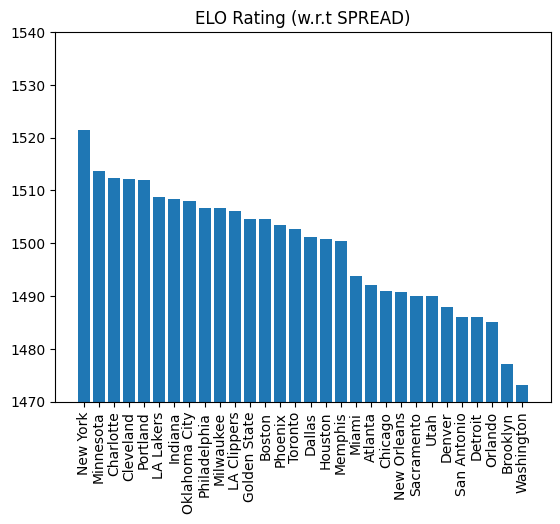

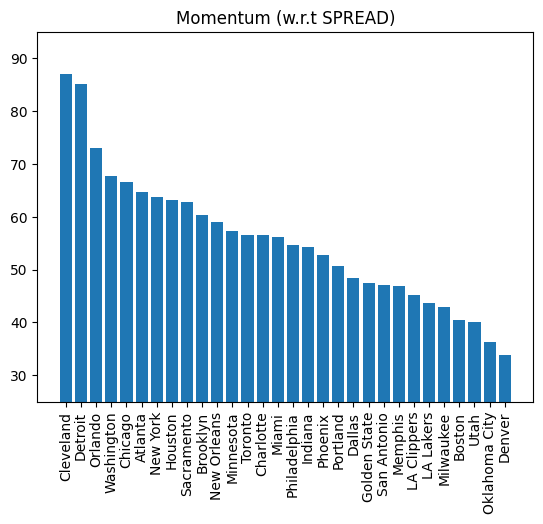

In [14]:
# most recent elo ratings and momentum scores from historical data
elo_ratings = most_recent_historical.set_index('TEAM')['Elo_Rating'].to_dict()
variances = most_recent_historical.set_index('TEAM')['Elo_Var'].to_dict()
momentum_scores = most_recent_historical.set_index('TEAM')['Momentum'].to_dict()

# elo ratings is a dict of team names to elo ratings, and variances is a dict of team names to elo variances
# combine them into a single dict with team as key, mu as elo rating, and sigma as elo variance
team_strengths = {team: {'mu': elo_ratings[team], 'sigma2': variances[team]} for team in elo_ratings}

# Iterate over the new data to update Elo and Momentum
for index, row in just_yesterday_df.iterrows():
    team_elo, _, team_momentum, opp_elo, _, opp_momentum = niu.update_bayesian_elo_momentum(row, just_yesterday_df, team_strengths, momentum_scores)
    # Update the dictionaries with the new Elo and momentum values
    elo_ratings[row['TEAM']] = team_elo
    momentum_scores[row['TEAM']] = team_momentum
    elo_ratings[row['Opponent']] = opp_elo
    momentum_scores[row['Opponent']] = opp_momentum
    variances[row['TEAM']] = team_strengths[row['TEAM']]['sigma2']
    variances[row['Opponent']] = team_strengths[row['Opponent']]['sigma2']

# sort elo ratings and plot on a bar chart
sorted_elo = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_elo)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(1470, 1540)
plt.title("ELO Rating (w.r.t SPREAD)")
plt.show()
# pp.pprint(elo_ratings)
# print()
# print("Updated Momentum Scores:")
# pp.pprint( momentum_scores)
sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_momentum)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(25, 95)
plt.title("Momentum (w.r.t SPREAD)")
plt.show()


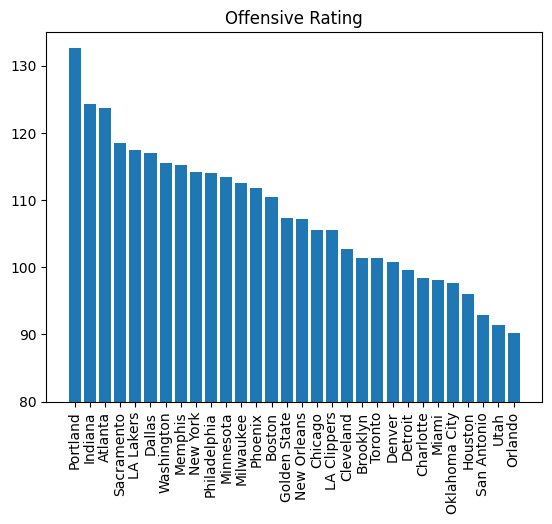

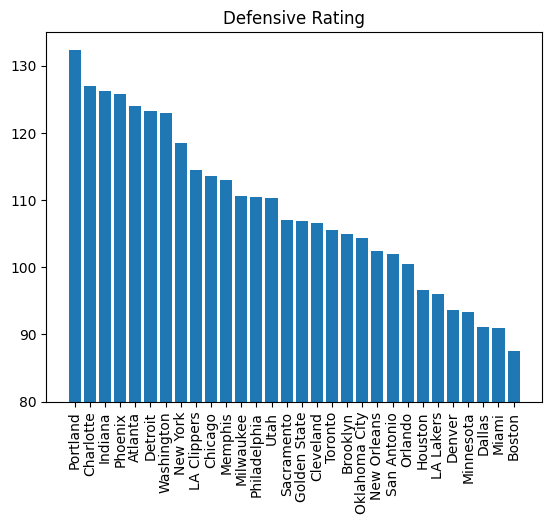

In [15]:
# most recent elo ratings and momentum scores from historical data
off_ratings = most_recent_historical.set_index('TEAM')['Offensive_Rating'].to_dict()
def_ratings = most_recent_historical.set_index('TEAM')['Defensive_Rating'].to_dict()
off_variances = most_recent_historical.set_index('TEAM')['Offensive_Var'].to_dict()
def_variances = most_recent_historical.set_index('TEAM')['Defensive_Var'].to_dict()
momentum_scores = most_recent_historical.set_index('TEAM')['Momentum'].to_dict()

# elo ratings is a dict of team names to elo ratings, and variances is a dict of team names to elo variances
# combine them into a single dict with team as key, mu as elo rating, and sigma as elo variance
team_strengths2 = {team: {'offense': {'mu': off_ratings[team], 'sigma2': off_variances[team]}, 
                         'defense': {'mu': def_ratings[team], 'sigma2': def_variances[team]}} for team in elo_ratings}

# Iterate over the new data to update Elo and Momentum
for index, row in just_yesterday_df.iterrows():
    team_elo, team_elo_d, team_momentum, opp_elo, opp_elo_d, opp_momentum = niu.update_bayesian_off_def(row, just_yesterday_df, team_strengths2, momentum_scores)
    # Update the dictionaries with the new Elo and momentum values
    try:
        team_strengths2[row['TEAM']]['mu'] = team_elo['mu']
        team_strengths2[row['TEAM']]['mu'] = team_elo_d['mu']
        team_strengths2[row['TEAM']]['sigma2'] = team_elo['sigma2']
        momentum_scores[row['TEAM']] = team_momentum
        team_strengths2[row['Opponent']]['mu'] = opp_elo['mu']
        team_strengths2[row['Opponent']]['mu'] = opp_elo_d['mu']
        team_strengths2[row['Opponent']]['sigma2'] = opp_elo['sigma2']
        momentum_scores[row['Opponent']] = opp_momentum
    except Exception as e:
        print(e)
        pass

# Output the updated Elo ratings and momentum scores
#print("Updated Offensive Ratings:", off_ratings)
sorted_off = sorted(off_ratings.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_off)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(80, 135)
plt.title("Offensive Rating")
plt.show()

sorted_def = sorted(def_ratings.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_def)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(80, 135)
plt.title("Defensive Rating")
plt.show()
#print("Updated Defensive Ratings:", def_ratings)
#print("Updated Momentum Scores:", momentum_scores)


### Update TODAY_MAP with new elo/momentum (opps too)

In [16]:
# convert index to TEAM column in TODAY_MAP

TODAY_MAP['ELO_Rating'] = TODAY_MAP['TEAM'].map(elo_ratings)
TODAY_MAP['Offensive_Rating'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['offense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Defensive_Rating'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['defense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Offensive_Var'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['offense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Defensive_Var'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['defense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Offensive_Var'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['offense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Defensive_Var'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['defense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Momentum'] = TODAY_MAP['TEAM'].map(momentum_scores)
TODAY_MAP['Opp_Elo'] = TODAY_MAP['Opponent'].map(elo_ratings)
TODAY_MAP['Elo_Var'] = TODAY_MAP['TEAM'].map(variances) 
TODAY_MAP['Opp_Elo_Var'] = TODAY_MAP['Opponent'].map(variances)
TODAY_MAP['Opp_Offensive_Rating'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['offense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Defensive_Rating'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['defense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP[['SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3']] = pd.DataFrame(TODAY_MAP['Spread_Movement'].to_list(), index=TODAY_MAP.index)
TODAY_MAP[['TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3']] = pd.DataFrame(TODAY_MAP['Total_Movement'].to_list(), index=TODAY_MAP.index)
TODAY_MAP[['OPP_SPREAD_MOVEMENT_1', 'OPP_SPREAD_MOVEMENT_2', 'OPP_SPREAD_MOVEMENT_3']] = TODAY_MAP['Opponent'].map(TODAY_MAP.set_index('TEAM')[['SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3']].to_dict('index')).apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))
TODAY_MAP[['OPP_TOTAL_MOVEMENT_1', 'OPP_TOTAL_MOVEMENT_2', 'OPP_TOTAL_MOVEMENT_3']] = TODAY_MAP['Opponent'].map(TODAY_MAP.set_index('TEAM')[['TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3']].to_dict('index')).apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))

TODAY_MAP['Opp_Momentum'] = TODAY_MAP['Opponent'].map(momentum_scores)
TODAY_MAP[['TEAM', 'Opponent', 'Offensive_Rating', 'Defensive_Rating', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'ELO_Rating', 'Opp_Elo', 'Momentum', 'Opp_Momentum', ]]



,TEAM,Opponent,Offensive_Rating,Defensive_Rating,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL,ELO_Rating,Opp_Elo,Momentum,Opp_Momentum
0,Charlotte,LA Clippers,98.374290,127.035785,575,13.0,208.5,1512.375385,1506.064156,56.514605,45.120779
1,LA Clippers,Charlotte,105.547024,114.543521,-850,-13.0,208.5,1506.064156,1512.375385,45.120779,56.514605
2,Detroit,Dallas,99.539712,123.259212,-102,1.0,228.5,1486.070118,1501.093112,85.073763,48.480863
3,Dallas,Detroit,117.012487,91.082470,-118,-1.0,228.5,1501.093112,1486.070118,48.480863,85.073763
4,Philadelphia,Denver,114.062800,110.398670,320,9.5,234.0,1506.747509,1487.978396,54.691625,33.853900
5,Denver,Philadelphia,100.787662,93.608380,-410,-9.5,234.0,1487.978396,1506.747509,33.853900,54.691625
6,Toronto,Chicago,101.350529,105.580374,-170,-4.0,232.0,1502.658392,1490.869203,56.625155,66.645392
7,Chicago,Toronto,105.616564,113.587562,142,4.0,232.0,1490.869203,1502.658392,66.645392,56.625155
8,San Antonio,Milwaukee,92.823912,101.939653,102,1.5,235.0,1486.119441,1506.614638,47.093245,43.011041
9,Milwaukee,San Antonio,112.474805,110.639136,-122,-1.5,235.0,1506.614638,1486.119441,43.011041,47.093245


In [19]:
t_features = list(total_model.feature_names_in_)
s_features = list(spread_model.feature_names_in_)
ml_features = list(ml_model.feature_names_in_)
#s_inf_features = list(spread_model.feature_names_in_)

### update rolling stats, collect features, and perform inference

In [20]:
# get all the rolling stats for today
most_recent_tdf = niu.get_rolling_stats(yesterday_df, today_teams_list)
today_features = TODAY_MAP[today_map_features + ['Offensive_Var', 'Defensive_Var', 'Opp_Offensive_Var', 'Opp_Defensive_Var']]

# merge most_recent_tdf with today_features on TEAM
infer_df = most_recent_tdf.merge(today_features, how='left', on='TEAM')
# convert categorical columns
infer_df['MAIN REF'] = infer_df['Referee'].astype('category')
infer_df['TEAM'] = infer_df['TEAM'].astype('category')
infer_df['CREW'] = infer_df['CREW'].astype('category')
infer_df['Opponent'] = infer_df['Opponent_y'].astype('category')
infer_df['TEAM_REST_DAYS'] = infer_df['TEAM_REST_DAYS'].astype('category')

# fix merged column names
infer_df['MONEYLINE'] = infer_df['MONEYLINE_y']
infer_df['VENUE'] = infer_df['Venue']
infer_df['CLOSING_SPREAD'] = infer_df['CLOSING_SPREAD_y']
infer_df['CLOSING_TOTAL'] = infer_df['CLOSING_TOTAL_y']
infer_df['Elo_Rating'] = infer_df['ELO_Rating']
# convert datatypes
infer_df['VENUE'] = (infer_df['VENUE'] == 'H')*1
infer_df[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]] = (
        infer_df[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]]
        .replace('even', '-100', regex=True)
        .fillna(0)
        .astype(int)
    )
temp_df = infer_df.dropna(subset=['TEAM', 'Opponent'])
temp_df[['TEAM', 'Opponent']].dropna()

# filter down to train cols
#infer_df = infer_df[train_cols +['DATE', 'GAME-ID', 'Offensive_Var', 'Defensive_Var', 'Opp_Offensive_Var', 'Opp_Defensive_Var', 'one_week_totals']]
#infer_df = infer_df[inf_features]
# s_infer_df = infer_df[s_inf_features]
# Get predictions from the ensemble models
infer_df = infer_df.sort_values(by='DATE')
infer_df = infer_df.drop_duplicates(subset=['TEAM'], keep='last')
spread_probabilities = spread_model.predict_proba(infer_df[s_features])[:, 1]
total_probabilities = total_model.predict_proba(infer_df[t_features])[:, 1]
ml_probabilities = ml_model.predict_proba(infer_df[ml_features])[:, 1]


real_probabilities = {}
processed_games = set()
ps = {team: prob for team, prob in zip(temp_df['TEAM'], total_probabilities)}
for team, opp in zip(temp_df['TEAM'], temp_df['Opponent']):
    # Ensure we process each game only once
    game = tuple(sorted([team, opp]))
    if game not in processed_games:
        processed_games.add(game)
        # Sum probabilities of both teams and divide by 2
        prob_team = ps[team]
        prob_opp = ps[opp]
        average_prob = (prob_team + prob_opp) / 2
        # Assign the average probability to both teams
        real_probabilities[team] = average_prob
        real_probabilities[opp] = average_prob
    else:
        # If the game is already processed, assign the existing average probability
        average_prob = real_probabilities[team]
        
# Update the probabilities mapping with the averaged probabilities
ps = real_probabilities
spread_predictions = np.array([x > 0.5 for x in spread_probabilities])
ml_predictions = np.array([x > 0.5 for x in ml_probabilities])
total_predictions = np.array([x > 0.5 for x in total_probabilities])

infer_df['spread_prob'] = spread_probabilities
infer_df['ml_prob'] = ml_probabilities
infer_df['total_prob'] = total_probabilities

# get the results
today_results = infer_df[['TEAM', 'Opponent', 'MONEYLINE',
                        'CLOSING_SPREAD', 'CLOSING_TOTAL',
                        'spread_prob', 'ml_prob', 'total_prob']].dropna().reset_index(drop=True)

spread_ps = {team: prob for team, prob in zip(today_results['TEAM'].values, spread_probabilities)}
normed_spread_odds = {team: spread_ps[team]/(spread_ps[team] + spread_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}
ml_ps = {team: prob for team, prob in zip(today_results['TEAM'].values, ml_probabilities)}
normed_ml_odds = {team: ml_ps[team]/(ml_ps[team] + ml_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}
total_ps = ps #{team: prob for team, prob in zip(today_results['TEAM'].values, total_probabilities)}
normed_total_odds = ps #{team: total_ps[team]/(total_ps[team] + total_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}

today_results['spread_prob_normed'] = today_results['TEAM'].map(normed_spread_odds)
today_results['ml_prob_normed'] = today_results['TEAM'].map(normed_ml_odds)
today_results['total_prob_normed'] = today_results['TEAM'].map(normed_total_odds)
today_results['total_prob'] = today_results['TEAM'].map(normed_total_odds)

In [21]:
BR = 500
unit = BR/10

# convert CLOSING_SPREAD to implied probability
today_results['CLOSING_SPREAD_LINE'] = -110
today_results['CLOSING_TOTAL_LINE'] = -110
today_results['spread_implied_prob'] = today_results['CLOSING_SPREAD_LINE'].apply(niu.odds_to_implied_prob)
today_results['total_implied_prob'] = today_results['CLOSING_TOTAL_LINE'].apply(niu.odds_to_implied_prob)
today_results['total_implied_prob'] = today_results['MONEYLINE'].apply(niu.odds_to_implied_prob)
# add column to today_results for kelly criterion
today_results['spread_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['spread_prob_normed'], -110, temper=0.5), axis=1)
today_results['total_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['total_prob_normed'], -110, temper=0.5), axis=1)
today_results['ml_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['ml_prob_normed'], -110, temper=0.5), axis=1)


### TOTALS

In [22]:


print('PREDICTED OVERS')
over_df = today_results[(today_results['total_prob'] > 0.5)]
over_df["sorted_pair"] = over_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
over_df = over_df.drop_duplicates(subset="sorted_pair", keep="first")

total_frame = today_results.drop_duplicates(subset=['TEAM'])
display(over_df[(total_frame['total_prob'] > 0.5)] \
.sort_values('total_prob', ascending=False)[['TEAM', 'Opponent','CLOSING_TOTAL',
                                                'total_prob', 'total_kelly']])
under_df = total_frame[(total_frame['total_prob'] <= 0.5)]
under_df['total_prob'] = 1 - under_df['total_prob']
under_df["sorted_pair"] = under_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
under_df = under_df.drop_duplicates(subset="sorted_pair", keep="first")
under_df['total_kelly'] = under_df.apply(lambda x: niu.kelly_criterion(unit, x['total_prob'], -110, temper=0.5), axis=1)
print('\nPREDICTED UNDERS\n')
display(under_df \
.sort_values('total_prob', ascending=False)[['TEAM', 'Opponent','CLOSING_TOTAL',
                                                'total_prob', 'total_kelly']])

PREDICTED OVERS


,TEAM,Opponent,CLOSING_TOTAL,total_prob,total_kelly
0,Milwaukee,San Antonio,235.0,0.833634,16.265792
6,Chicago,Toronto,232.0,0.736430,11.162587
1,Charlotte,LA Clippers,208.5,0.693379,8.902386
3,Detroit,Dallas,228.5,0.649065,6.575895



PREDICTED UNDERS



,TEAM,Opponent,CLOSING_TOTAL,total_prob,total_kelly
7,Denver,Philadelphia,234.0,0.874174,18.394115
2,Golden State,Phoenix,228.5,0.624657,5.294467
10,New Orleans,Boston,232.5,0.558836,1.838909


### MONEYLINE

In [36]:
today_results[today_results['ml_kelly'] > 0][['TEAM', 'Opponent','MONEYLINE','ml_prob_normed', 'ml_kelly']].sort_values('ml_prob_normed', ascending=False)

,TEAM,Opponent,MONEYLINE,ml_prob_normed,ml_kelly
12,LA Clippers,Charlotte,-850,0.587747,3.356717
8,Toronto,Chicago,-170,0.568557,2.349263
0,Milwaukee,San Antonio,-122,0.557888,1.789115
10,New Orleans,Boston,410,0.547630,1.250564
3,Detroit,Dallas,-102,0.533381,0.502504


### SPREAD

In [37]:
today_results[today_results['spread_kelly'] > 0][['TEAM', 'Opponent','spread_prob_normed', 'spread_kelly']].sort_values('spread_prob_normed', ascending=False)

,TEAM,Opponent,spread_prob_normed,spread_kelly
10,New Orleans,Boston,0.979999,23.949930
7,Denver,Philadelphia,0.780796,13.491789
1,Charlotte,LA Clippers,0.713967,9.983279
2,Golden State,Phoenix,0.577178,2.801856
6,Chicago,Toronto,0.544341,1.077901


### EXTRAS

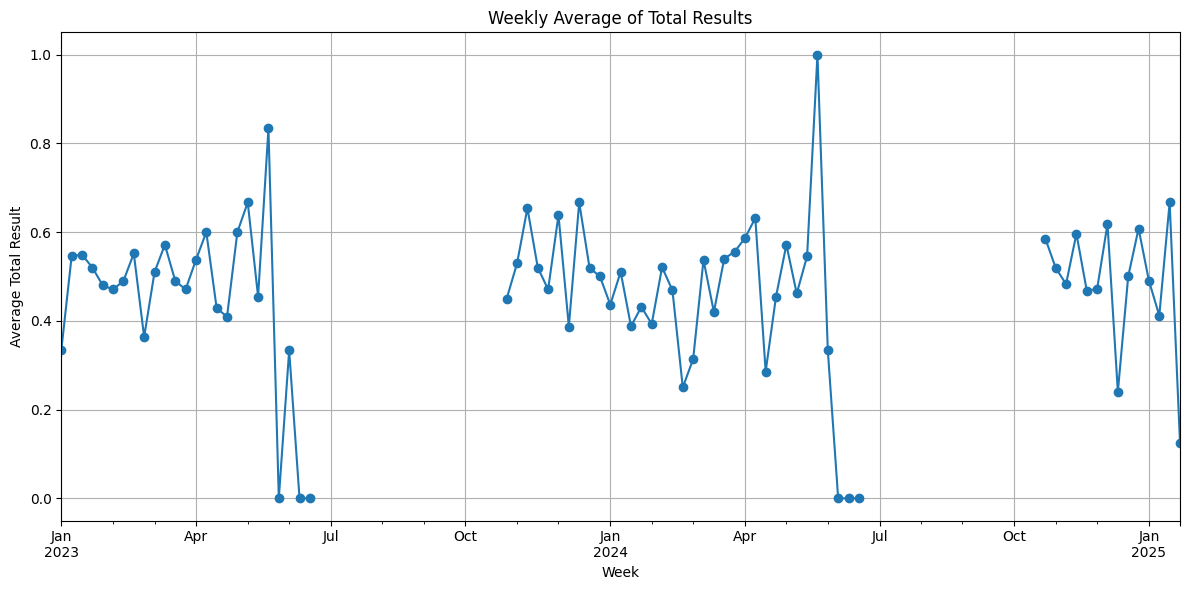

In [116]:
# Ensure 'DATE' is in datetime format
historical_data['DATE'] = pd.to_datetime(historical_data['DATE'])

this_year_data = historical_data[historical_data['DATE'].dt.year >= 2023]
# Convert 'total_result' to integer
this_year_data['total_result'] = historical_data['total_result'].astype(int)

#list of freq values
#freq_values = ['D', 'W', 'M', 'Q', 'Y']
# Group by week using Grouper and calculate the mean
weekly_data = this_year_data.groupby(pd.Grouper(key='DATE', freq='W'))['total_result'].mean()

# Plot the weekly average of 'total_result'
plt.figure(figsize=(12, 6))
weekly_data.plot(marker='o', linestyle='-')
plt.title('Weekly Average of Total Results')
plt.xlabel('Week')
plt.ylabel('Average Total Result')
plt.grid(True)
plt.tight_layout()
plt.show()
